<h2><center>AI in Healthcare</center></h2>
<h3><center>Smart Home Activities Prediction</h3>

The objective of this lab is to learn to apply the LSTM to the data collectd from Halmstad University's Smart Home

In [1]:
#from mat4py import loadmat
from scipy.io import loadmat

import numpy as np
from numpy import array
from numpy import argmax

import pandas as pd
from pandas import DataFrame
from pandas import concat

import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

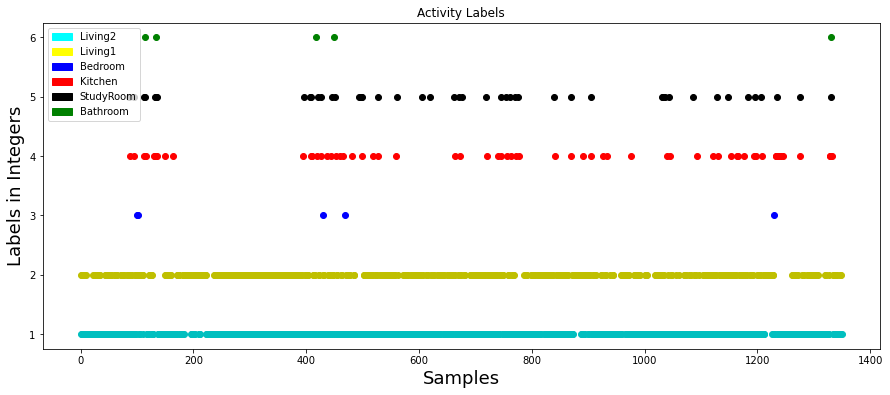

In [2]:
data = loadmat(os.getcwd() + '/Data.mat')

DatesVectors = np.array(data['DatesVectors'])
SensorsVals = np.array(data['SensorsVals'])
Labels = np.array(data['Labels'])
Labels = Labels[7401:,:]

SensorsVals = SensorsVals.astype('int')
SensorsVals = SensorsVals[7401:,:]
SensorsVals = np.concatenate(SensorsVals,axis=0)

TrainLabels=Labels
TrainLabels=np.ravel(TrainLabels)
TrainLabels=np.array(TrainLabels)

Classes=['Living2','Living1','Bedroom','Kitchen','Study','Bathroom']
Indexes=[] # creat an empty list
for kk in range(len(Classes)):
    lbl=Classes[kk]
    idx=np.argwhere(TrainLabels==lbl)
    Indexes.append(idx)
    
Colors=['c','y','b','r','k','g']
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.title('Activity Labels')
for kk in range(len(Indexes)):
    idx=np.array(Indexes[kk])
    for jj in range(len(idx)):
        ax.plot(idx[jj],SensorsVals[idx[jj]],'o',color=Colors[kk],label=Classes[kk])
        
ax.set_ylabel('Labels in Integers',fontsize=18)
ax.set_xlabel('Samples',fontsize=18)

blue_patch = mpatches.Patch(color='blue', label='Bedroom')
red_patch = mpatches.Patch(color='red', label='Kitchen')
green_patch = mpatches.Patch(color='green', label='Bathroom')
cyan_patch = mpatches.Patch(color='cyan', label='Living2')
yellow_patch = mpatches.Patch(color='yellow', label='Living1')
black_patch = mpatches.Patch(color='black', label='StudyRoom')


ax.legend(handles=[cyan_patch,yellow_patch,blue_patch,red_patch,black_patch,green_patch])


# Lab Instructions

You are supposed to do a sequence of integers prediction using LSTM.

First, try to visualize what you have in the SensorsVals. The values of SensorsVals are already concatanated into a an array integers.

You expose the LSTM to a sequence of observation. Then, the LSTM is going to do the prediciton of the sequence after some training (sequence to sequence model).

You may try your own methodology. The suggestion is to:
- One hot encode the SensorsVals varialbles (encoded)
- Frame the encoded sequences for learning 




In [3]:
SensorsVals.size

1350

In [4]:
print(SensorsVals[:500])

[2 1 2 1 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 1 2 1 1
 1 1 1 1 1 1 2 1 2 1 2 2 1 2 1 1 2 2 1 1 1 1 2 1 1 2 2 1 2 1 1 1 1 1 2 2 1
 1 2 1 2 1 1 1 1 2 1 2 1 5 4 2 1 1 2 1 1 4 5 1 2 2 1 3 3 2 2 1 1 2 2 2 2 2
 1 4 5 6 5 4 1 1 1 1 1 2 2 2 2 2 1 1 1 4 5 4 5 6 5 4 1 1 1 1 1 1 1 1 1 1 1
 1 4 2 1 2 2 1 2 1 1 2 1 1 2 1 1 4 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 2 1 1 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 1 2 1 1 2 1 2 1 2 1 1 2
 1 1 2 1 2 1 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 1 2 1 2 1 2 1 1 1 2
 2 1 1 1 2 2 1 2 1 2 1 2 1 1 2 1 2 1 1 2 2 1 1 2 1 2 1 1 2 1 2 1 2 1 1 1 2
 2 1 1 1 2 2 1 1 2 1 1 1 2 1 2 1 2 1 1 2 2 1 2 1 2 1 1 2 1 2 1 2 1 2 1 2 1
 1 2 1 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 1 2 1 1 2 1 4 5 1 2 1 2 1 1 2 2 1 1
 5 4 5 4 1 2 2 1 2 1 1 6 4 5 1 2 2 1 1 5 4 1 2 3 2 1 1 1 1 1 4 1 2 1 2 2 1
 4 5 1 2 2 1 6 5 4 1 2 2 1 1 1 1 4 1 2 2 1 1 4 1 3 1 1 2 2 1 1 2 1 2 1 1 1
 4 1 1 2 2 1 1 1 1 1 1 1 

In [5]:
print(Labels[:])

[[array(['Living1'], dtype='<U7')]
 [array(['Living2'], dtype='<U7')]
 [array(['Living1'], dtype='<U7')]
 ...
 [array(['Living2'], dtype='<U7')]
 [array(['Living1'], dtype='<U7')]
 [array(['Living2'], dtype='<U7')]]


# One Hot Encoding

Inspiration taken from: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [6]:
Labels.size

1350

In [7]:
Labels[0][0][0]

'Living1'

In [8]:
Labels[0][0]

array(['Living1'], dtype='<U7')

In [9]:
Labels[0]

array([array(['Living1'], dtype='<U7')], dtype=object)

In [10]:
labels = []
temp = []
for label in Labels:
    labels = label[0][0]
    temp.append(labels)
    
values = array(temp)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

['Living1' 'Living2' 'Living1' ... 'Living2' 'Living1' 'Living2']
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
['Living1']


In [43]:
print('Index for value 1: \n', np.where(SensorsVals == 1))
print('\n Index for One Hot Encoded value in one of the indices: ',onehot_encoded[1])

Index for value 1: 
 (array([   1,    3,    5,    7,    8,   10,   11,   12,   13,   14,   15,
         16,   17,   18,   19,   20,   21,   23,   24,   26,   27,   28,
         30,   31,   33,   35,   36,   37,   38,   39,   40,   41,   42,
         44,   46,   49,   51,   52,   55,   56,   57,   58,   60,   61,
         64,   66,   67,   68,   69,   70,   73,   74,   76,   78,   79,
         80,   81,   83,   85,   89,   90,   92,   93,   96,   99,  104,
        105,  111,  117,  118,  119,  120,  121,  127,  128,  129,  137,
        138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
        151,  154,  156,  157,  159,  160,  162,  163,  165,  166,  167,
        168,  169,  170,  176,  177,  178,  179,  180,  183,  195,  197,
        198,  199,  201,  202,  209,  210,  211,  223,  224,  225,  226,
        227,  228,  229,  230,  231,  232,  233,  234,  235,  237,  239,
        240,  241,  243,  244,  245,  247,  249,  250,  252,  254,  256,
        257,  259,  260,  262

In [41]:
print('Index for value 2: \n', np.where(SensorsVals == 2))
print('\n Index for One Hot Encoded value in one of the indices: ',onehot_encoded[0])

Index for value 2: 
 (array([   0,    2,    4,    6,    9,   22,   25,   29,   32,   34,   43,
         45,   47,   48,   50,   53,   54,   59,   62,   63,   65,   71,
         72,   75,   77,   82,   84,   88,   91,   97,   98,  102,  103,
        106,  107,  108,  109,  110,  122,  123,  124,  125,  126,  150,
        152,  153,  155,  158,  161,  171,  172,  173,  174,  175,  181,
        182,  184,  185,  186,  187,  188,  189,  190,  191,  192,  193,
        194,  196,  200,  203,  204,  205,  206,  207,  208,  212,  213,
        214,  215,  216,  217,  218,  219,  220,  221,  222,  236,  238,
        242,  246,  248,  251,  253,  255,  258,  261,  263,  265,  268,
        270,  272,  274,  276,  278,  280,  282,  285,  287,  289,  291,
        295,  296,  300,  301,  303,  305,  307,  310,  312,  315,  316,
        319,  321,  324,  326,  328,  332,  333,  337,  338,  341,  345,
        347,  349,  352,  353,  355,  357,  360,  362,  364,  366,  368,
        371,  373,  375,  377

In [39]:
print('Index for value 3: \n', np.where(SensorsVals == 3))
print('\n Index for One Hot Encoded value in one of the indices: ',onehot_encoded[100])

Index for value 3: 
 (array([ 100,  101,  430,  468, 1230]),)

 Index for One Hot Encoded value in one of the indices:  [0. 1. 0. 0. 0. 0.]


In [37]:
print('Index for value 4: \n', np.where(SensorsVals == 4))
print('\n Index for One Hot Encoded value in one of the indices: ',onehot_encoded[87])

Index for value 4: 
 (array([  87,   94,  112,  116,  130,  132,  136,  149,  164,  395,  408,
        410,  419,  427,  437,  444,  452,  460,  466,  481,  498,  519,
        528,  560,  663,  672,  720,  740,  746,  756,  763,  771,  777,
        841,  870,  890,  905,  927,  934,  976, 1039, 1045, 1093, 1121,
       1130, 1153, 1164, 1166, 1176, 1194, 1197, 1208, 1232, 1233, 1234,
       1238, 1242, 1246, 1276, 1328, 1329, 1332]),)

 Index for One Hot Encoded value in one of the indices:  [0. 0. 1. 0. 0. 0.]


In [31]:
print('Index for value 5: \n', np.where(SensorsVals == 5))
print('\n Index for One Hot Encoded value in one of the indices: ',onehot_encoded[86])

Index for value 5: 
 (array([  86,   95,  113,  115,  131,  133,  135,  396,  407,  409,  420,
        426,  445,  451,  493,  497,  499,  527,  561,  606,  619,  662,
        671,  677,  719,  745,  755,  762,  770,  776,  840,  869,  904,
       1030, 1033, 1036, 1044, 1086, 1129, 1148, 1184, 1195, 1207, 1235,
       1275, 1331]),)

 Index for One Hot Encoded value in one of the indices:  [0. 0. 0. 0. 0. 1.]


In [35]:
print('Index for value 6: \n', np.where(SensorsVals == 6))
print('\n Index for One Hot Encoded value in one of the indices: ', onehot_encoded[114])

Index for value 6: 
 (array([ 114,  134,  418,  450, 1330]),)

 Index for One Hot Encoded value in one of the indices:  [1. 0. 0. 0. 0. 0.]


# Data Preparation

Inspiration taken from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [11]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
# number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(onehot_encoded, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 1. 0. 0.]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 1. 0. 0.]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 1. 0. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 0. 1. 0.]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]] [0. 0. 0. 0.

In [12]:
print(f'Input sequence: {SensorsVals[:3]}\nCorresponding output sequence: {SensorsVals[3]}\n')
print(f'Encoded input sequence: \n{X[0]}\nEncoded corresponding output sequence: {y[0]}')

Input sequence: [2 1 2]
Corresponding output sequence: 1

Encoded input sequence: 
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]
Encoded corresponding output sequence: [0. 0. 0. 0. 1. 0.]


# Split the data in test & train 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# LSTM model

In [14]:
# define model
n_features = 6 #number of features
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(6, activation='softmax'))
#model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             11400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
Total params: 31,906
Trainable params: 31,906
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [16]:
EPOCHS = 100
model.fit(x_train, 
          y_train, 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test)
         )

Epoch 1/100
34/34 [==============================] - 1s 22ms/step - loss: 1.6951 - accuracy: 0.5218 - val_loss: 1.5329 - val_accuracy: 0.5407
Epoch 2/100
34/34 [==============================] - 1s 17ms/step - loss: 1.1694 - accuracy: 0.5710 - val_loss: 1.1736 - val_accuracy: 0.5407
Epoch 3/100
34/34 [==============================] - 1s 17ms/step - loss: 0.9830 - accuracy: 0.5766 - val_loss: 1.1005 - val_accuracy: 0.5407
Epoch 4/100
34/34 [==============================] - 1s 18ms/step - loss: 0.9660 - accuracy: 0.5710 - val_loss: 1.0863 - val_accuracy: 0.5407
Epoch 5/100
34/34 [==============================] - 1s 18ms/step - loss: 0.9562 - accuracy: 0.5710 - val_loss: 1.0787 - val_accuracy: 0.5407
Epoch 6/100
34/34 [==============================] - 1s 17ms/step - loss: 0.9515 - accuracy: 0.5710 - val_loss: 1.0638 - val_accuracy: 0.5407
Epoch 7/100
34/34 [==============================] - 1s 18ms/step - loss: 0.9478 - accuracy: 0.5710 - val_loss: 1.0705 - val_accuracy: 0.5407
Epoch 

# Predictions

In [17]:
predictions = model.predict(x_test)

In [18]:
print(predictions)

[[6.89421315e-04 8.13944847e-04 5.29929623e-02 5.08608878e-01
  3.98057133e-01 3.88376378e-02]
 [3.43868160e-03 2.36491696e-03 3.53591554e-02 9.38949883e-02
  7.76810229e-01 8.81320238e-02]
 [6.80927653e-04 7.84048717e-03 8.45697534e-04 6.81255102e-01
  3.05808127e-01 3.56968120e-03]
 ...
 [1.21990945e-02 3.15581933e-02 5.77698760e-02 3.34167361e-01
  5.19896448e-01 4.44090329e-02]
 [2.38977940e-04 6.62330247e-04 4.11257185e-02 2.97540158e-01
  6.37063444e-01 2.33694073e-02]
 [2.25782875e-04 1.03317457e-03 2.29869550e-03 2.41508678e-01
  7.40652263e-01 1.42814154e-02]]


# Confusion Matrix

Inspiration taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [19]:
conf_mat = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=predictions.argmax(axis=1))

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))
    plt.show()

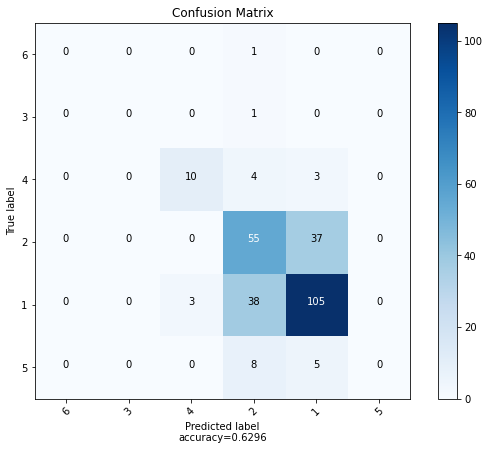

In [44]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['6', '3', '4', '2', '1', '5'],
                      title        = "Confusion Matrix")